<a href="https://colab.research.google.com/github/hubertrykala93/US_health_insurance_regression_prediction/blob/main/US_health_insurance_regression_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [784]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, RANSACRegressor, SGDRegressor, Ridge, Lasso
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

np.set_printoptions(suppress=True, edgeitems=30, linewidth=100000,
                    formatter=dict(float=lambda x: f'{x:.8f}'))
np.random.seed(42)

sns.set()

pd.options.display.float_format = '{:,.8f}'.format
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 100)

In [785]:
path = '/content/insurance.csv'

In [786]:
raw_data = pd.read_csv(filepath_or_buffer=path)
data = raw_data.copy()

In [787]:
# Checking head of DataFrame
data.head(n=5)

age     sex         bmi  children smoker     region         charges
0   19  female 27.90000000         0    yes  southwest 16,884.92400000
1   18    male 33.77000000         1     no  southeast  1,725.55230000
2   28    male 33.00000000         3     no  southeast  4,449.46200000
3   33    male 22.70500000         0     no  northwest 21,984.47061000
4   32    male 28.88000000         0     no  northwest  3,866.85520000

In [788]:
# Basic information about numerical columns
data.describe()

age            bmi       children         charges
count 1,338.00000000 1,338.00000000 1,338.00000000  1,338.00000000
mean     39.20702541    30.66339686     1.09491779 13,270.42226514
std      14.04996038     6.09818691     1.20549274 12,110.01123669
min      18.00000000    15.96000000     0.00000000  1,121.87390000
25%      27.00000000    26.29625000     0.00000000  4,740.28715000
50%      39.00000000    30.40000000     1.00000000  9,382.03300000
75%      51.00000000    34.69375000     2.00000000 16,639.91251500
max      64.00000000    53.13000000     5.00000000 63,770.42801000

In [789]:
# Basic information about DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [790]:
# How many null values in DataFrame?
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [791]:
# Checking duplicated rows
data[data.duplicated()]

age   sex         bmi  children smoker     region        charges
581   19  male 30.59000000         0     no  northwest 1,639.56310000

In [792]:
# Removing duplicated rows
data.drop_duplicates(inplace=True)

Data Analysis

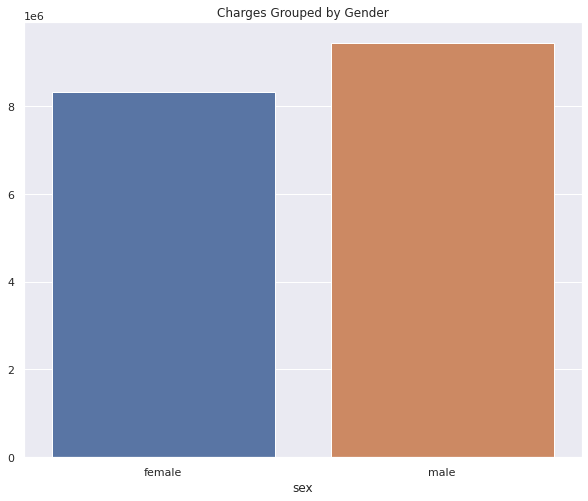

In [793]:
# Charges grouped by gender
plt.figure(figsize=(10, 8))
sns.barplot(data=data, x=data.groupby(by='sex', sort=True)['charges'].sum().index,
            y=data.groupby(by='sex', sort=True)['charges'].sum().values)
plt.title(label='Charges Grouped by Gender')
plt.show()

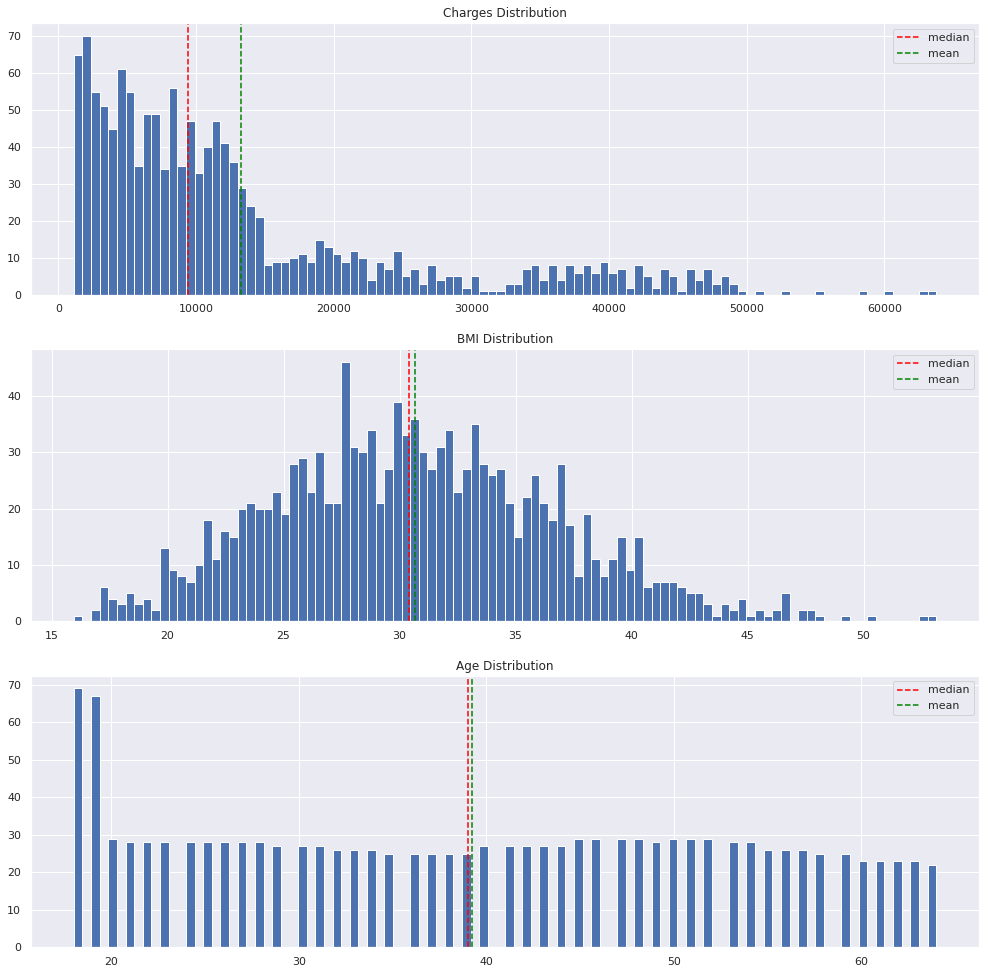

In [794]:
# Checking histograms for numerical columns
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(17, 17))
ax[0].hist(x=data['charges'], bins=100)
ax[0].axvline(x=data['charges'].median(), linestyle='--', color='red', label='median')
ax[0].axvline(x=data['charges'].mean(), linestyle='--', color='green', label='mean')
ax[0].set_title(label='Charges Distribution')
ax[0].legend(loc='best')
ax[1].hist(x=data['bmi'], bins=100)
ax[1].axvline(x=data['bmi'].median(), linestyle='--', color='red', label='median')
ax[1].axvline(x=data['bmi'].mean(), linestyle='--', color='green', label='mean')
ax[1].set_title(label='BMI Distribution')
ax[1].legend(loc='best')
ax[2].hist(x=data['age'], bins=100)
ax[2].axvline(x=data['age'].median(), linestyle='--', color='red', label='median')
ax[2].axvline(x=data['age'].mean(), linestyle='--', color='green', label='mean')
ax[2].set_title(label='Age Distribution')
ax[2].legend(loc='best')
plt.show()

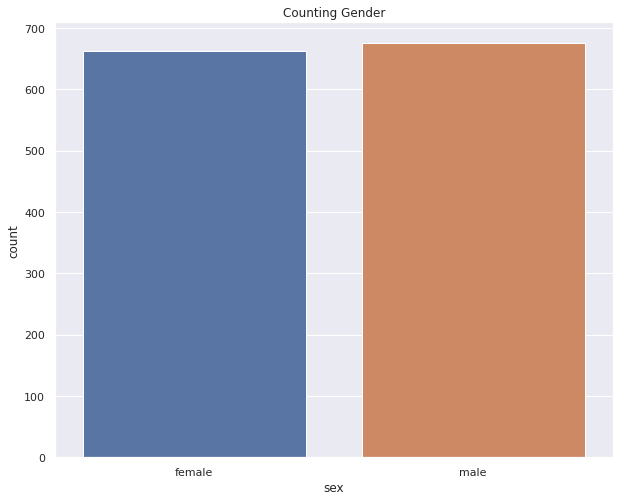

In [795]:
# Counting gender
plt.figure(figsize=(10, 8))
sns.countplot(x='sex', data=data)
plt.title(label='Counting Gender')
plt.show()

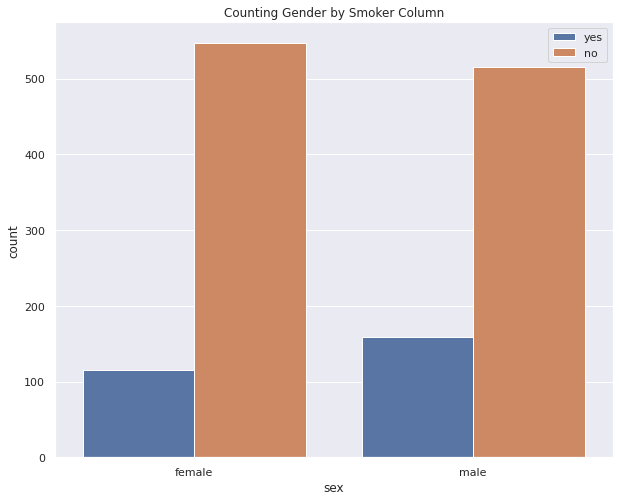

In [796]:
# Counting gender by smoker column
plt.figure(figsize=(10, 8))
sns.countplot(x='sex', data=data, hue='smoker')
plt.title(label='Counting Gender by Smoker Column')
plt.legend(loc='best')
plt.show()

In [797]:
# Counting gender by smoker column and number of children
plt.figure(figsize=(10, 8))
sns.countplot(x='sex', data=data, hue='children')
plt.title(label='Counting Gender by Number of Children')
plt.legend(loc='best')
plt.show()

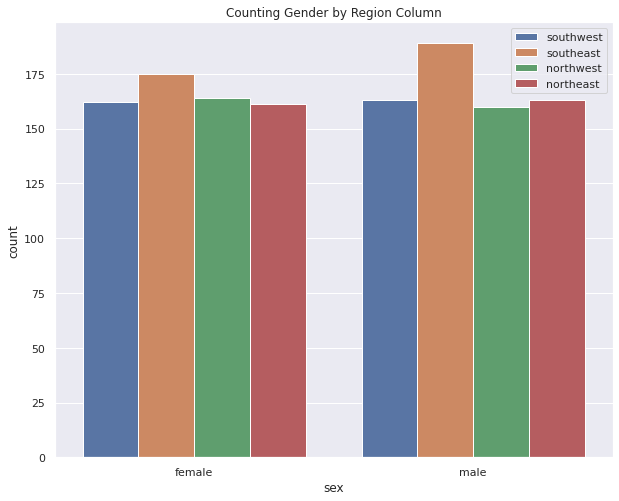

In [798]:
# Counting gender by region
plt.figure(figsize=(10, 8))
sns.countplot(x='sex', data=data, hue='region')
plt.title(label='Counting Gender by Region Column')
plt.legend(loc='best')
plt.show()

In [799]:
# Aggregation charges by regions
plt.figure(figsize=(10, 8))
sns.barplot(data=data, x=data.groupby(by='region')['charges'].sum().index,
            y=data.groupby(by='region')['charges'].sum().values)
plt.title(label='Aggregation Charges by Regions')
plt.show()

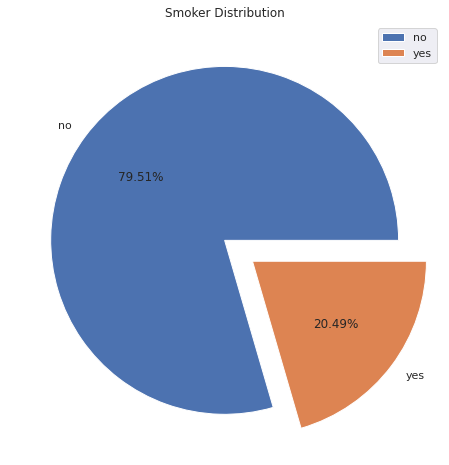

In [800]:
# Smoker distribution
plt.figure(figsize=(10, 8))
plt.pie(x=data['smoker'].value_counts().values, labels=data['smoker'].value_counts().index,
        autopct='%.2f%%', explode=(0, 0.2))
plt.title(label='Smoker Distribution')
plt.legend(loc='best')
plt.show()

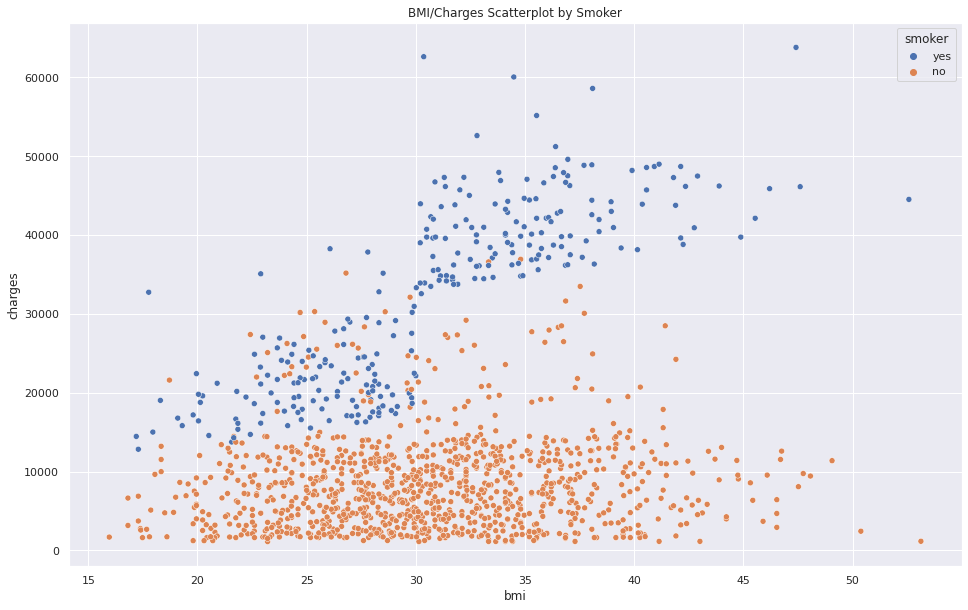

In [801]:
# BMI/Charges scatterplot by smoker
plt.figure(figsize=(16, 10))
sns.scatterplot(data=data, x='bmi', y='charges', hue='smoker')
plt.title(label='BMI/Charges Scatterplot by Smoker')
plt.show()

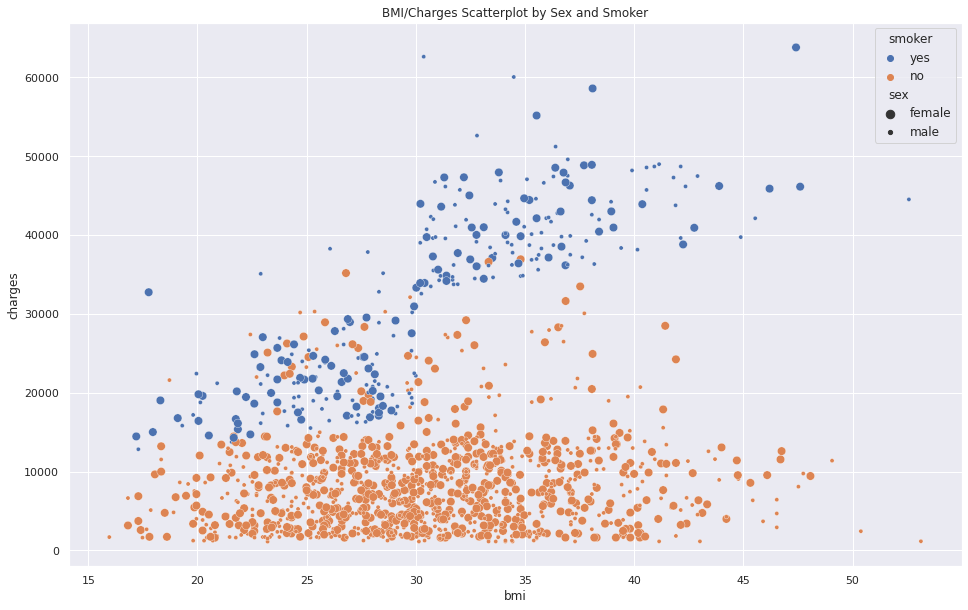

In [802]:
# BMI/Charges Scatterplot by Sex and Smoker
plt.figure(figsize=(16, 10))
sns.scatterplot(data=data, x='bmi', y='charges', hue='smoker', size='sex')
plt.title(label='BMI/Charges Scatterplot by Sex and Smoker')
plt.show()

Data Preprocessing

In [803]:
# Creating Auxiliary Columns
data['bmi_degree'] = data['bmi'].apply(
    func=lambda
        x: 'starvation' if (x < 17) else 'underweight' if (
            x > 17 and x <= 18.49) else 'correct' if (
            x > 18.50 and x <= 24.99) else 'overweight' if (
            x > 25 and x <= 29.99) else 'first degree of obesity' if (
            x > 30 and x <= 34.99) else 'second degree of obesity' if (
            x > 35 and x < 39.9) else 'extreme obesity')

data['life_stages'] = data['age'].apply(func=lambda x: 'infancy' if (
    x > 0 and x <= 2) else 'early childhood' if (
    x > 2 and x <= 5) else 'first middle childhood' if (
    x > 5 and x <= 8) else 'second middle childhood' if (
    x > 8 and x <= 13) else 'early adolescence' if (
    x > 13 and x <= 18) else 'late adolescence' if (
    x > 18 and x <= 23) else 'early adulthood' if (
    x > 23 and x <= 35) else 'middle adulthood' if (
    x > 35 and x <= 61) else 'late adulthood')

data['has_children'] = data['children'].apply(func=lambda x: 'no' if x == 0 else 'yes')

In [804]:
data.head(n=5)

age     sex         bmi  children smoker     region         charges               bmi_degree        life_stages has_children
0   19  female 27.90000000         0    yes  southwest 16,884.92400000               overweight   late adolescence           no
1   18    male 33.77000000         1     no  southeast  1,725.55230000  first degree of obesity  early adolescence          yes
2   28    male 33.00000000         3     no  southeast  4,449.46200000  first degree of obesity    early adulthood          yes
3   33    male 22.70500000         0     no  northwest 21,984.47061000                  correct    early adulthood           no
4   32    male 28.88000000         0     no  northwest  3,866.85520000               overweight    early adulthood           no

In [805]:
# Encoding categorical variables with Ordinal Encoder
for column in data.columns:
    if data[column].dtype == 'object':
        encoder = OrdinalEncoder()
        data[column] = encoder.fit_transform(X=data[[column]])

In [806]:
# Correlation Matrix visualization
plt.figure(figsize=(14, 10))
sns.heatmap(data=data.corr(), annot=True, fmt='.2f')
plt.title(label='Correlation Matrix')
plt.show()

In [807]:
# Converting some types of columns to categorical integer
data['children'] = data['children'].astype(dtype='int')
data['sex'] = data['sex'].astype(dtype='int')
data['smoker'] = data['smoker'].astype(dtype='int')
data['region'] = data['region'].astype(dtype='int')
data['bmi_degree'] = data['bmi_degree'].astype(dtype='int')
data['life_stages'] = data['life_stages'].astype(dtype='int')
data['has_children'] = data['has_children'].astype(dtype='int')

Define X and y

In [808]:
# Making X and y
X = data.drop(columns='charges')
y = data['charges']

In [809]:
# Train and test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [810]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (935, 9)
X_test shape: (402, 9)
y_train shape: (935,)
y_test shape: (402,)


In [811]:
# Scaling X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X=X_train)
X_test = scaler.transform(X=X_test)

In [812]:
# Creating DataFrame with models and statistics to find out the best model
models_list = []

models_list.append([LinearRegression(), RANSACRegressor(), SGDRegressor(),
                    Ridge(), Lasso(), LinearSVR(), SVR(), KNeighborsRegressor(),
                    DecisionTreeRegressor(), RandomForestRegressor(),
                    GradientBoostingRegressor(), AdaBoostRegressor(),
                    GaussianProcessRegressor()])

def regression_models_scores(y_test, models_list: list,
                  is_plot_visible=False):
    """
    Searching the best prediction model from the list and results visualization
    on bar chart and DataFrame.
    :param y_test: numpy.ndarray
    :param models_list: list
    :param is_plot_visible: boolean
    :return: pandas.DataFrame, seaborn.barplot
    """

    r2_scores = []
    mae = []
    mse = []

    for model in models_list[0]:
        classifier = model
        classifier.fit(X=X_train, y=y_train)
        y_pred = classifier.predict(X=X_test)

        r2_scores.append(r2_score(y_true=y_test, y_pred=y_pred))
        mae.append(mean_absolute_error(y_true=y_test, y_pred=y_pred))
        mse.append(mean_squared_error(y_true=y_test, y_pred=y_pred))

    names = [str(model)[:str(model).index('(')] for model in models_list[0]]

    results = pd.DataFrame(data={
        'name': names,
        'r2_scores': r2_scores,
        'mae': mae,
        'mse': mse,
    })

    if is_plot_visible:
        plt.figure(figsize=(12, 8))
        sns.barplot(x=r2_scores, y=names,
                    orient='h')
        plt.show()

    return results.sort_values(by='r2_scores', ascending=False).reset_index(drop=True)

In [813]:
regression_models_scores(y_test=y_test, models_list=models_list, is_plot_visible=False)

name   r2_scores             mae                  mse
0   GradientBoostingRegressor  0.87161930  2,594.78751016  21,968,210.94511278
1       RandomForestRegressor  0.86433507  2,639.77764685  23,214,672.60247768
2           AdaBoostRegressor  0.84663236  4,038.20238801  26,243,918.58042734
3         KNeighborsRegressor  0.79629560  3,620.81092319  34,857,430.53417678
4       DecisionTreeRegressor  0.78542503  2,743.26916980  36,717,576.31662470
5            LinearRegression  0.77171405  4,192.08339306  39,063,768.37104125
6                       Lasso  0.77169767  4,192.04550188  39,066,572.08537684
7                       Ridge  0.77151492  4,194.59351280  39,097,842.64782708
8                SGDRegressor  0.77077826  4,213.38056639  39,223,898.29702436
9             RANSACRegressor  0.52469707  4,282.21878872  81,332,747.96857296
10                        SVR -0.11890097  8,806.23323284 191,463,769.30398577
11                  LinearSVR -0.97426291 12,911.76346574 337,831,343.92506593
12   GaussianProcessRegressor -1.60127296 10,900.10468032 445,123,866.89445579

Define model

In [814]:
# Creating GradientBoostingRegressor
model = GradientBoostingRegressor()

In [815]:
# Find out the best params for model using GridSearchCV
params = {'learning_rate': [0.01, 0.02, 0.03, 0.04],
          'subsample': [0.9, 0.5, 0.2, 0.1],
          "min_samples_split": [5],
          'n_estimators': [100, 150, 200, 500, 1000],
          'max_depth': [4]
          }

grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1)
grid_search.fit(X=X_train, y=y_train)
y_pred = grid_search.predict(X=X_test)

In [816]:
# GridSearch the best params
grid_search.best_params_

{'learning_rate': 0.02,
 'max_depth': 4,
 'min_samples_split': 5,
 'n_estimators': 150,
 'subsample': 0.9}

In [817]:
# r2 score result
r2_score = r2_score(y_true=y_test, y_pred=y_pred)
print(f'R2_score: {r2_score}')

R2_score: 0.8720603121330104


In [818]:
# Creating DataFrame with True and Predicted values
prediction_results = pd.DataFrame(data={
    'True': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred
}).reset_index(drop=True)

In [819]:
prediction_results

True       Predicted           Error
0    8,688.85885000 10,237.24653288 -1,548.38768288
1    5,708.86700000  7,178.53135387 -1,469.66435387
2   11,436.73815000 12,855.16942850 -1,418.43127850
3   38,746.35510000 42,304.38942182 -3,558.03432182
4    4,463.20510000  5,947.85252522 -1,484.64742522
..              ...             ...             ...
397  5,148.55260000  6,369.69545740 -1,221.14285740
398 11,363.28320000 12,660.09320034 -1,296.81000034
399 10,600.54830000 11,728.04604565 -1,127.49774565
400 13,429.03540000 14,155.28524452   -726.24984452
401 24,603.04837000  8,663.23191002 15,939.81645998

[402 rows x 3 columns]

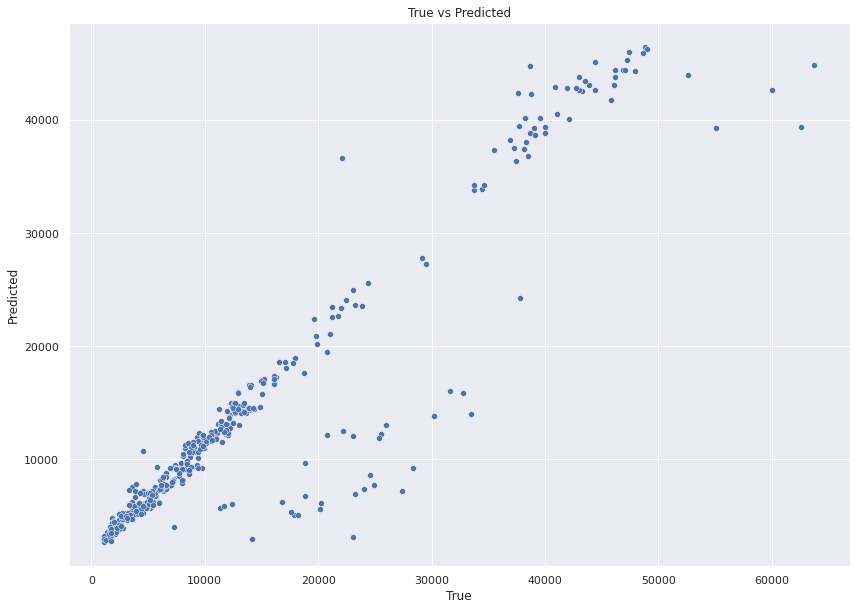

In [820]:
# Scatterplot with True vs Predicted values
plt.figure(figsize=(14, 10))
sns.scatterplot(data=prediction_results, x='True', y='Predicted')
plt.xlabel(xlabel='True')
plt.ylabel(ylabel='Predicted')
plt.title(label='True vs Predicted')
plt.show()

In [821]:
# Save results to csv file
prediction_results.to_csv(path_or_buf='/content/prediction_results.csv')